In [1]:
from nbodykit.cosmology import Planck15
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mul = np.multiply
power = np.power
div = np.divide
add = np.add
log = np.log
sub = np.subtract
exp = np.exp
sinc = np.sinc

In [3]:

def get_Pk_EH(Omega0_m, cosmo, z, k):
    Omega0_m = np.broadcast_to(Omega0_m, np.shape(k))
    Obh2 = mul(cosmo.Omega0_b, power(cosmo.h, 2))
    Omh2 = mul(Omega0_m, power(cosmo.h, 2))
    f_baryon = div(cosmo.Omega0_b, Omega0_m)
    theta_cmb = div(cosmo.Tcmb0 , 2.7)

    # z and wavenumber of equality
    z_eq = mul(mul(2.5e4, Omh2),power(theta_cmb, -4)) # this is 1 + z
    k_eq = mul(mul(0.0746, Omh2),power(theta_cmb ,-2)) # units of 1/Mpc

    # sound horizon and k_silk
    z_drag_b1 = mul(mul(0.313, power(Omh2, -0.419)), add(1, mul(0.607,power(Omh2, 0.674))))
    z_drag_b2 = mul(0.238, power(Omh2,0.223))
    z_drag    = mul(div(mul(1291, power(Omh2, 0.251)), add(1., mul(0.659, power(Omh2, 0.828)))), add(1., mul(z_drag_b1, power(Obh2, z_drag_b2))))



    r_drag = div(mul(mul(mul(31.5, Obh2), power(theta_cmb, -4)), 1000.), add(1,z_drag))
    r_eq   = div(mul(mul(mul(31.5, Obh2), power(theta_cmb, -4)), 1000.), add(1,z_eq))

    sound_horizon = mul(mul(div(2., mul(3.,k_eq)),power(div(6., r_eq), .5)), \
                    log(div(add(power(add(1,r_drag), .5), power(add(r_drag,r_eq), .5)), add(1, power(r_eq, .5)))))

    k_silk = mul(mul(mul(1.6,power( Obh2, 0.52)), power(Omh2,0.73)),add(1, power(mul(10.4,Omh2), -0.95)))

    # alpha_c
    alpha_c_a1 = mul(power(mul(46.9,Omh2),0.670 ), add(1, power(mul(32.1,Omh2), -0.532)))
    alpha_c_a2 = mul(power(mul(12.0,Omh2), 0.424), add(1, power(mul(45.0,Omh2), -0.582)))
    alpha_c = mul(power(alpha_c_a1, -f_baryon), power(alpha_c_a2 , power(-f_baryon,3)))

    # beta_c
    beta_c_b1 = div(0.944, add(1, power(mul(458,Omh2), -0.708)))
    beta_c_b2 = mul(0.395, power(Omh2, -0.0266))
    beta_c = div(1., add(1 , sub(mul(beta_c_b1, power(sub(1,f_baryon), beta_c_b2)), 1)))

    y = div(z_eq, add(1, z_drag))
    alpha_b_G = mul(y, \
                    add(mul(-6.,power(add(1,y), .5)),
                        mul(add(2.,mul(3.,y)),
                            log(div(add(power(add(1,y), .5),1),sub(power(add(1,y), .5),1))))))
    alpha_b = mul(mul(mul(2.07,  k_eq), sound_horizon), mul(power(add(1,r_drag),-0.75), alpha_b_G))

    beta_node = mul(8.41, power(Omh2, 0.435))
    beta_b    = add(add(0.5, f_baryon), mul(sub(3., mul(2.,f_baryon)),power( add(power(mul(17.2,Omh2), 2), 1 ), .5)))


    k = k * cosmo.h # now in 1/Mpc

    q = div(k, mul(13.41,k_eq))
    ks = mul(k,sound_horizon)

    T_c_ln_beta   = log(add(np.e, mul(mul(1.8,beta_c),q)))
    T_c_ln_nobeta = log(add(np.e, mul(1.8,q)));

    T_c_C_alpha   = add(div(14.2, alpha_c), div(386., add(1, mul(69.9,power( q, 1.08)))))


    T_c_C_noalpha = add(14.2,  div(386., add(1, mul(69.9, power(q, 1.08)))))


    T_c_f = div(1., add(1.,power(div(ks,5.4), 4)))


    T_c = add(mul(T_c_f, f(T_c_ln_beta, T_c_C_noalpha, q)), mul(sub(1,T_c_f), f(T_c_ln_beta, T_c_C_alpha,q)))


    s_tilde = mul(sound_horizon, power(add(1, power(div(beta_node,ks),3)), (-1./3.)))


    ks_tilde = mul(k,s_tilde)


    T_b_T0 = f(T_c_ln_nobeta, T_c_C_noalpha, q)


    T_b_1 = div(T_b_T0, add(1, power(div(ks,5.2),2 )))


    T_b_2 = mul(div(alpha_b, add(1, power(div(beta_b,ks),3 ))), exp(-power(div(k,k_silk), 1.4)))


    T_b = mul(sinc(div(ks_tilde,np.pi)), add(T_b_1, T_b_2))

    T = add(mul(f_baryon,T_b), mul(sub(1,f_baryon),T_c));
    ### ADD GROWTH###
    omega_zs = get_omega_z(Omega0_m, z)
    omega_lambdas = get_omega_lambda(Omega0_m, z)
    growth_z = grow(omega_zs, omega_lambdas, z)
    omega_zs = get_omega_z(Omega0_m, 0)
    omega_lambdas = get_omega_lambda(Omega0_m, 0)
    growth_0 = grow(omega_zs, omega_lambdas, 0)

    factor = (k/cosmo.h)**cosmo.n_s

    Pk =mul(mul(power(T, 2), div(power(growth_z, 2),power(growth_0,2))),factor)
    return Pk

In [4]:

def f(a,b,q):
    return div(a, add(a ,mul( b, power(q,2))))

In [5]:
def get_omega_z(omega0_m, z):
    omega0_l = sub(1, omega0_m)
    num      = mul(omega0_m, (1+z)**3)
    denom    = omega0_l+ num
    return div(num, denom)

In [6]:

def grow(omega_z, omega_lambda, z):
    pre_fac = mul((1+z)**-1, div(mul(5, omega_z), 2))
    inside = power(
        add(sub(power(omega_z, 4/7), omega_lambda),
            mul(add(1, div(omega_z,2)),
                add(1, div(omega_lambda,70)))),
        -1)
    return mul(pre_fac, inside)

def get_omega_lambda(omega0_m, z):
    omega0_l = sub(1, omega0_m)
    denom = add(omega0_l, mul(omega0_m, (1+z)**3))
    return div(omega0_l, denom)

In [32]:
import mcfit    
from scipy.interpolate import InterpolatedUnivariateSpline as spline

In [127]:
ks = np.logspace(-4,1,100)
h = Planck15.h

In [313]:
def get_Pk_EH_model(Om):
    cosmo      = Planck15.clone(Omega_ncdm=0)
    cosmo      = cosmo.match(Omega0_cb=Om)
    Pk         = get_Pk_EH(Omega0_m=Om, cosmo=cosmo, z=0, k=ks)
    R, sigmasq = mcfit.TophatVar(ks, lowring=True)(Pk, extrap=True)
    
    norm = spline(R, sigmasq)(8)**.5
    norm = (cosmo.sigma8/norm)**2       
    
    return Pk*norm

def get_Pk(Om):
    
    cosmo = Planck15
    cosmo = cosmo.clone(Omega_ncdm=0)
    cosmo = cosmo.match(Omega0_cb=Om)
    Pk    = cosmo.get_pk(ks,z=0.)
    
    return Pk

In [314]:
Pk_nu = Planck15.get_pk(ks,z=0.)

In [316]:
Pk = get_Pk(Planck15.Omega0_m)

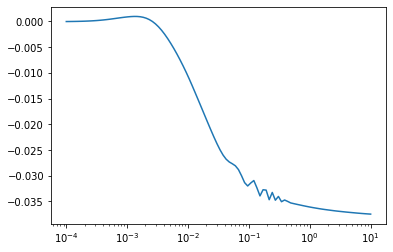

In [317]:
plt.semilogx(ks,(Pk_nu-Pk)/Pk)

In [318]:
def loss(Om):
    Pk  = get_Pk_model(Om)
    Pk_ = get_Pk(Om)
    loss = np.sum((Pk-Pk_)**2)
    print(Om,loss)
    return loss

In [320]:
Pk_ = get_Pk(Om=Planck15.Omega0_m)
Pk  = get_Pk_model(Om=Planck15.Omega0_m)

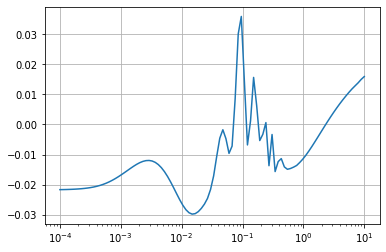

In [325]:
plt.semilogx(ks,(Pk-Pk_)/Pk_)
plt.grid()